# Sleep EEG preprocessing, spectral analyses and events detection

## Introductory notes:
This notebook presents minimal functionality needed to go through the cleaning, ICA and spectral analyses stages.
* For the cleaning part the functionality consists of resampling, filtering, bad channel selection and interpolation, and annotation of bad data spans.
* For the ICA part it is fitting and selecting components you want to exclude.
* For the spectral analyses part it is spectrogram+hypnogram, PSD per sleep stage and topomap per sleep stage per frequency band.
* For the events detection it is spindles, slow waves and rapid eye movements detection.

For the extended functionality check out corresponding notebooks.

### Import module
Add pipeline module to path and import its elements (just run this cell).

In [5]:
%matplotlib widget
import sys
sys.path.append('../sleepeeg')
from pipeline import CleaningPipe, ICAPipe, SpectralPipe, EventsPipe

## Cleaning

Initialize `CleaningPipe` object by providing it with path to eeg file and output directory in which you want the data to be saved.

In [6]:
pipe = CleaningPipe(
    path_to_eeg=r"C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff",
    output_dir=r"C:\Users\Gennadiy\Documents\data\HZ4\processing")

Reading EGI MFF Header from C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff...
    Reading events ...
    Assembling measurement info ...


### Resampling
This can take more than an hour depending on eeg signal size and specs of the computer you're running the analysis on.

In [8]:
pipe.resample(sfreq=250)

### Filtering
Bandpass and notch filters

In [9]:
pipe.filter(l_freq=0.3)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 2751 samples (11.004 sec)

Using CUDA for FFT FIR filtering


In [10]:
pipe.notch()

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Using CUDA for FFT FIR filtering


### Select bad channels and epochs

Select bad channels in the opened browser.

In [ ]:
pipe.plot()

Channels marked as bad:
['E9', 'E111', 'E145', 'E156', 'E165', 'E166', 'E219', 'E216', 'E174', 'E175', 'E187']


In [12]:
pipe.mne_raw.interpolate_bads(reset_bads=True)

Interpolating bad channels
    Automatic origin fit: head of radius 96.5 mm
Computing interpolation matrix from 236 sensor positions
Interpolating 21 sensors


<RawMff | signal1.bin, 264 x 2229773 (8919.1 s), ~4.39 GB, data loaded>

Select bad epochs

Click "a" -> "Add description" -> Enter BAD_EPOCH -> Annotate bad data spans

In [ ]:
pipe.plot(butterfly=True)

Channels marked as bad:
none


## ICA

Pass the preceding (cleaning) pipe to the ICA.

In [14]:
ica_pipe = ICAPipe(
    prec_pipe=pipe)

Fit the ICA on the 1 Hz high-pass fitered data.

In [ ]:
ica_pipe.fit()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 257 channels (please be patient, this may take a while)
Omitting 18810 of 2229773 (0.84%) samples, retaining 2210963 (99.16%) samples.
Selecting by number: 15 components
Fitting ICA took 84.3s.


Visually inspect ICA components.

In [ ]:
ica_pipe.plot_sources()

Creating RawArray with float64 data, n_channels=16, n_times=2229773
    Range : 0 ... 2229772 =      0.000 ...  8919.088 secs
Ready.


c:\Users\Gennadiy\Documents\eeg-processing-pipeline\notebooks\../sleepeeg\pipeline.py:173: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  self.mne_ica.plot_sources(self.mne_raw, block=True)


Pass to the `exclude` argument indices of components you want to remove from the raw signal.

In [ ]:
ica_pipe.apply(exclude=[11])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 257 PCA components


## Spectral

Pass the preceding (cleaning or ICA) pipe to the SpectralPipe. Also provide pass to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [15]:
spectral_pipe = SpectralPipe(
    prec_pipe=ica_pipe,
    path_to_hypno=r"C:\Users\Gennadiy\Documents\data\HZ4\staging.txt",
    hypno_freq=1)

31-Mar-23 17:51:32 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


Pass an electrode name to calculate spectrogram for (e.g., E101)

Setting 214732 of 2229773 (9.63%) samples to NaN, retaining 2015041 (90.37%) samples.


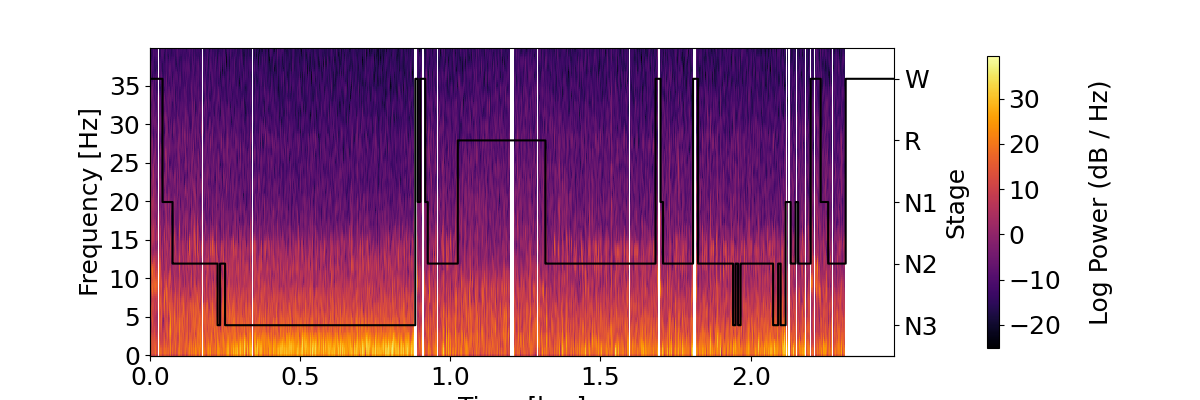

In [16]:
spectral_pipe.plot_hypnospectrogram(
    picks=['E101'],
    overlap=True)

Setting 214732 of 2229773 (9.63%) samples to NaN, retaining 2015041 (90.37%) samples.


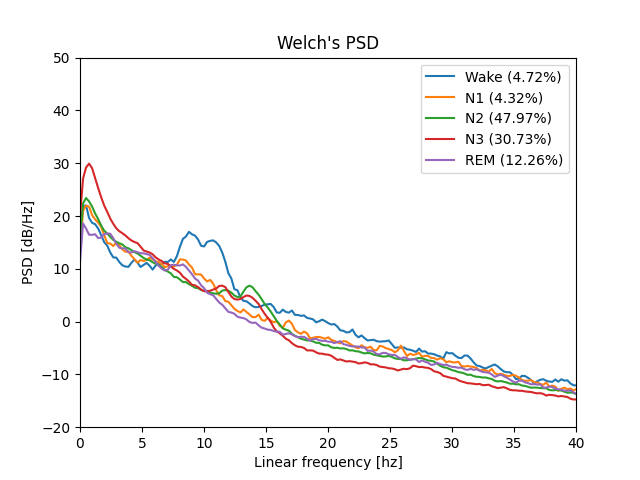

In [17]:
spectral_pipe.plot_psd_per_stage(
    picks=['E101'],
    psd_range=(-20, 50))

Create a collage with rows for sleep stages and columns for bands.

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting 214732 of 2229773 (9.63%) samples to NaN, retaining 2015041 (90.37%) samples.


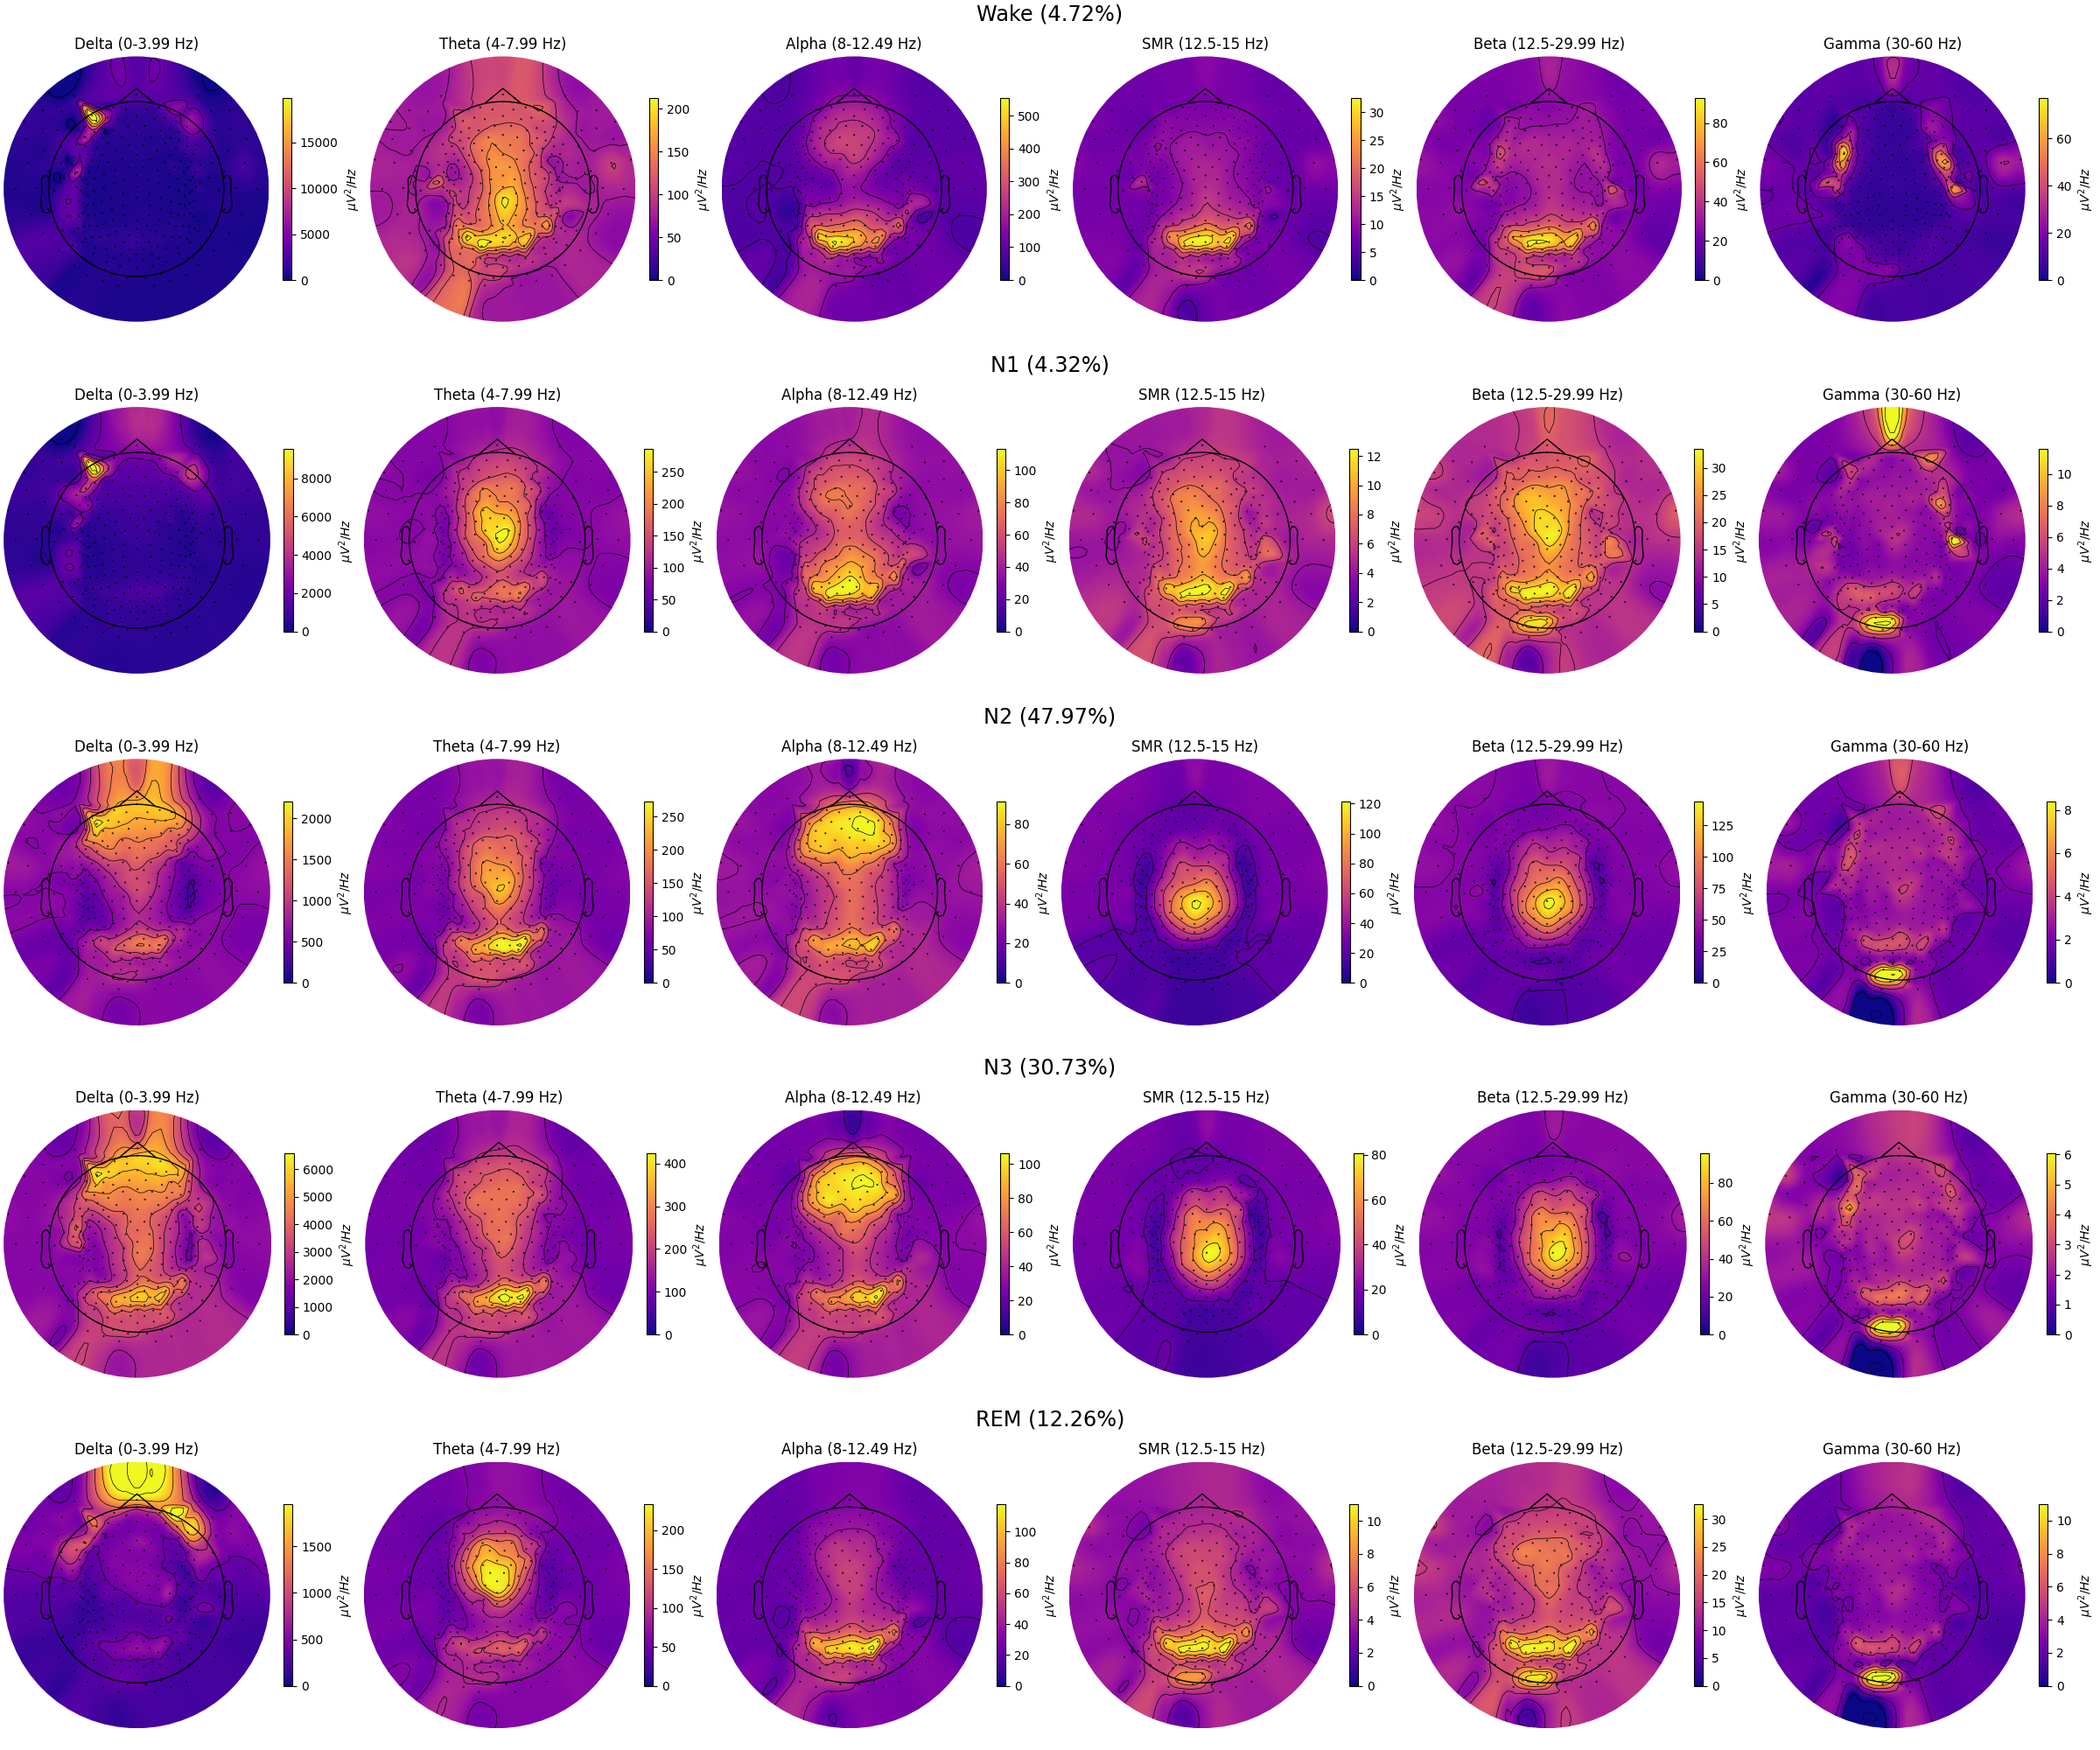

In [18]:
spectral_pipe.plot_topomap_collage()

## Events

Pass the preceding (cleaning or ICA or spectral) pipe to the EventsPipe. If the preceding is cleaning or ICA - provide pass to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [19]:
events_pipe = EventsPipe(
    prec_pipe=spectral_pipe)

31-Mar-23 17:52:12 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


In [21]:
events_pipe.spindles_detect()
events_pipe.sw_detect()
events_pipe.rem_detect()

31-Mar-23 18:00:11 | ERROR | Wrong data amplitude for VREF (trimmed STD = 0.000). Unit of data MUST be uV! Channel will be skipped.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0

Setting 214732 of 2229773 (9.63%) samples to NaN, retaining 2015041 (90.37%) samples.
Setting 214732 of 2229773 (9.63%) samples to NaN, retaining 2015041 (90.37%) samples.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


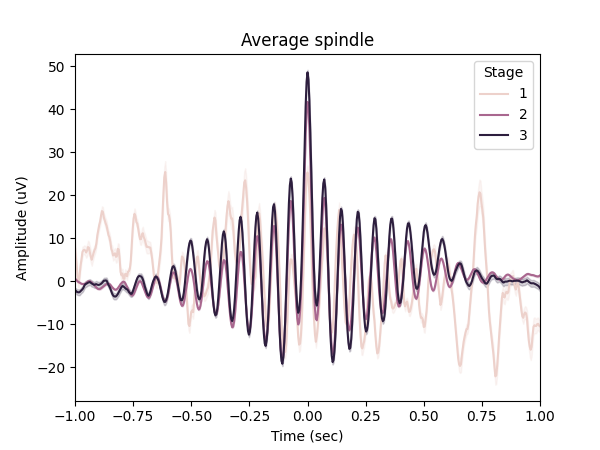

In [22]:
events_pipe.plot_spindles_average()

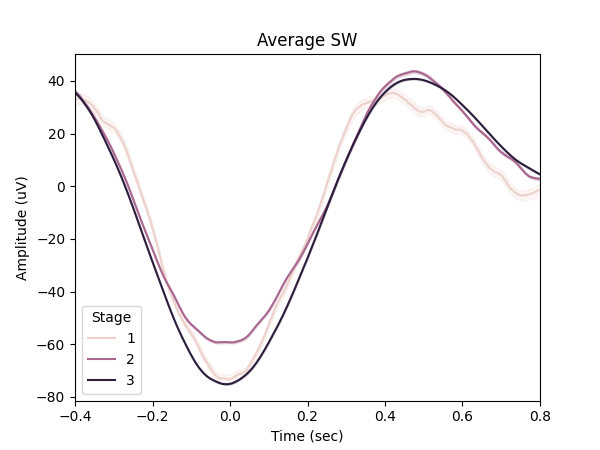

In [23]:
events_pipe.plot_slow_waves_average()

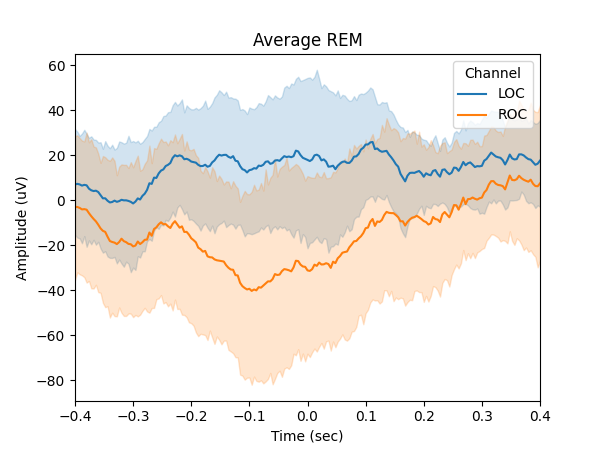

In [24]:
events_pipe.plot_rems_average()